## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#pickle.dump({ 'mtx': mtx, 'dist': dist }, open('../camera_cal/calibration.p', 'wb'))

In [4]:
def show_original_and_undistorted(img, mtx, dist):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(cv2.undistort(img, mtx, dist, None, mtx))
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    xorder = 1 if orient == 'x' else 0
    yorder = 0 if orient == 'x' else 1

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_sobel)

    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)

    # Rescale to 8 bit
    scaled_gradmag = np.uint8(255 * gradmag / np.max(gradmag))

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_gradmag)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1

    return binary_output


def dir_thresh(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Rescale back to 8 bit integer
    scaled_absgraddir = np.uint8(255 * absgraddir / np.max(absgraddir))
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_absgraddir)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_absgraddir >= thresh[0]) & (scaled_absgraddir <= thresh[1])] = 1

    return binary_output


def color_thresh(img, thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(s_channel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output


def stacked_color_and_gradient_thresh(sobelx_binary, s_channel_binary):
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    return np.dstack((np.zeros_like(sobelx_binary), sobelx_binary, s_channel_binary))


def combined_color_and_gradient_thresh(sobelx_binary, s_channel_binary):
    binary_output = np.zeros_like(sobelx_binary)
    binary_output[(s_channel_binary == 1) | (sobelx_binary == 1)] = 1
    
    return binary_output
                                              

def corners_unwarp(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    src_pt1, src_pt2, src_pt3, src_pt4 = generate_src_points(img.shape)
    src = np.float32([src_pt1, src_pt2, src_pt3, src_pt4])

    dst_pt1, dst_pt2, dst_pt3, dst_pt4 = generate_dst_points(img.shape)
    dst = np.float32([dst_pt1, dst_pt2, dst_pt3, dst_pt4])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, img_size)
        
    return warped, M


def generate_src_points(img_shape):
    img_size = (img_shape[1], img_shape[0])
    pt1 = (int(img_size[0] / 2 - 55), int(img_size[1] / 2 + 100))
    pt2 = (int(img_size[0] / 6 - 10), img_size[1])
    pt3 = (int(img_size[0] * 5 / 6 + 60), img_size[1])
    pt4 = (int(img_size[0] / 2 + 55), int(img_size[1] / 2 + 100))

    return pt1, pt2, pt3, pt4


def generate_dst_points(img_shape):
    img_size = (img_shape[1], img_shape[0])
    pt1 = (int(img_size[0] / 4), 0)
    pt2 = (int(img_size[0] / 4), img_size[1])
    pt3 = (int(img_size[0] * 3 / 4), img_size[1])
    pt4 = (int(img_size[0] * 3 / 4), 0)

    return pt1, pt2, pt3, pt4


def draw_lines(img, pt1, pt2, pt3, pt4, color=(255, 0, 0), thickness=3):
    cv2.line(img, pt1, pt2, color=color, thickness=thickness)
    cv2.line(img, pt2, pt3, color=color, thickness=thickness)
    cv2.line(img, pt3, pt4, color=color, thickness=thickness)
    cv2.line(img, pt4, pt1, color=color, thickness=thickness)
    
    
def draw_original_lines(img):
    src_pt1, src_pt2, src_pt3, src_pt4 = generate_src_points(img.shape)
    draw_lines(img, src_pt1, src_pt2, src_pt3, src_pt4)
    
    
def draw_warped_lines(img):
    dst_pt1, dst_pt2, dst_pt3, dst_pt4 = generate_dst_points(img.shape)
    draw_lines(img, dst_pt1, dst_pt2, dst_pt3, dst_pt4)
    
    
def sliding_windows(binary_warped, visualize=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

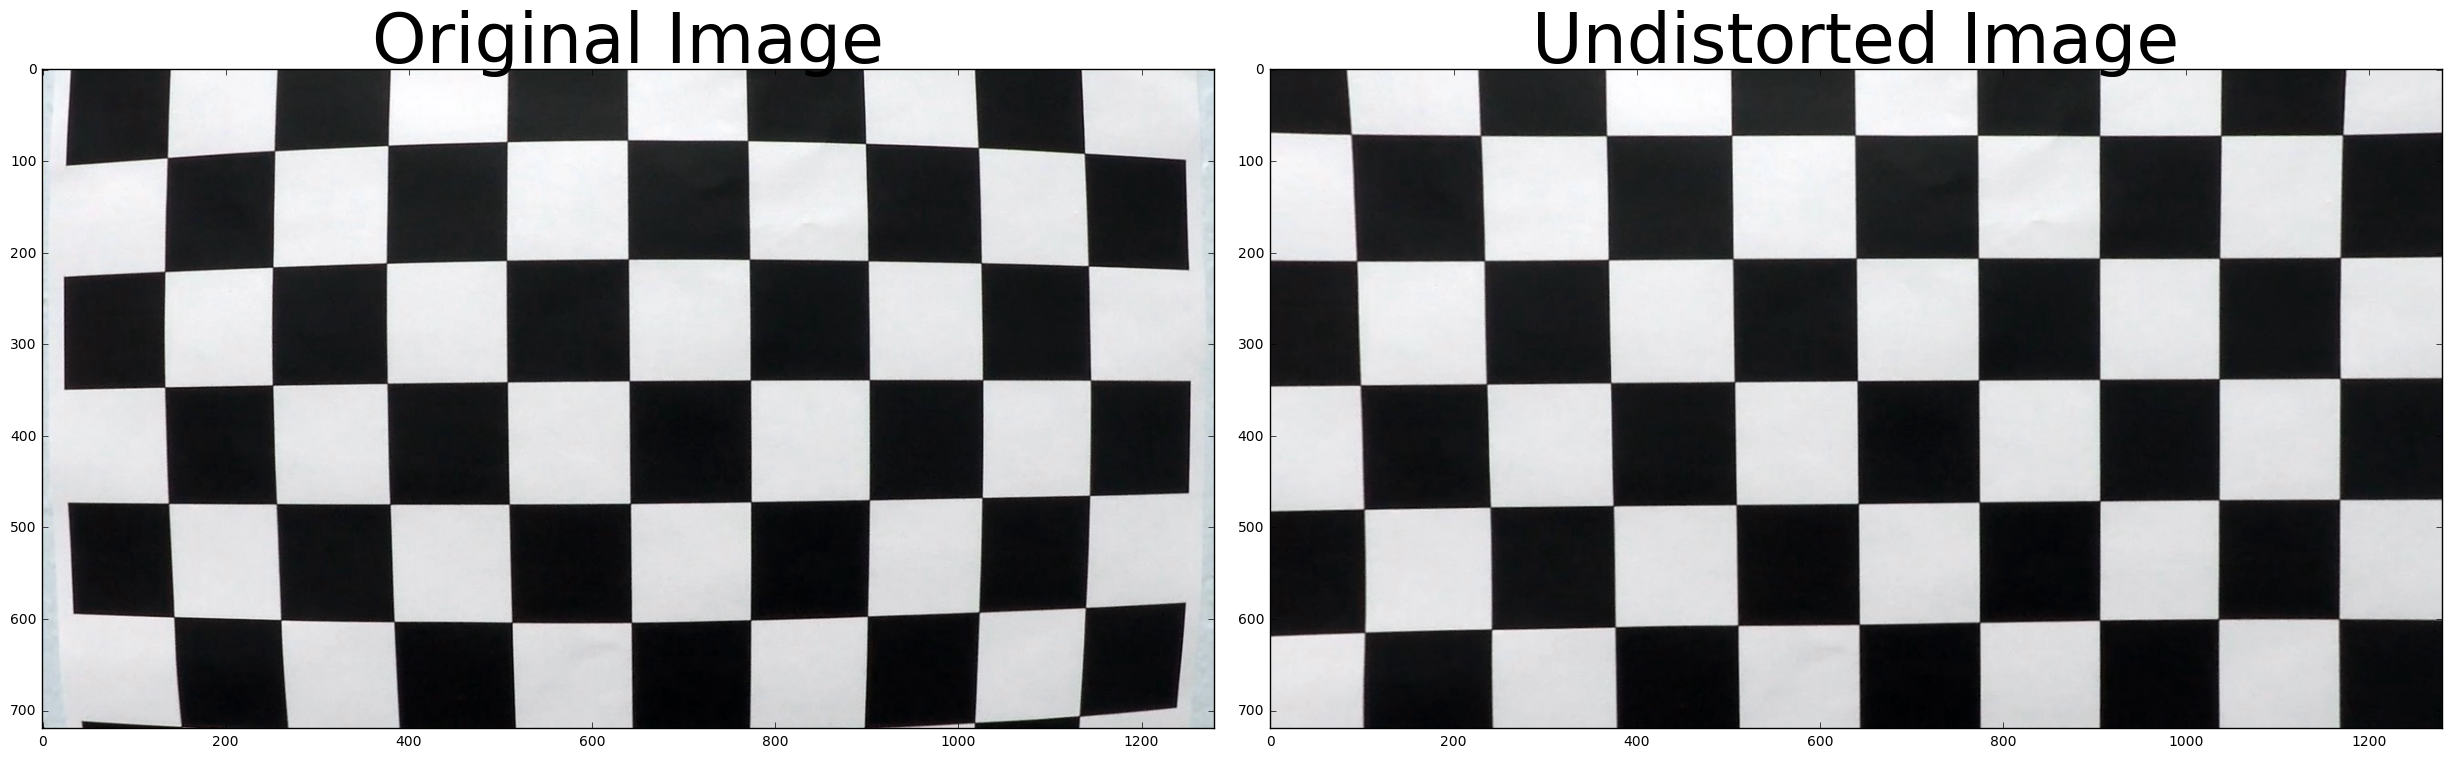

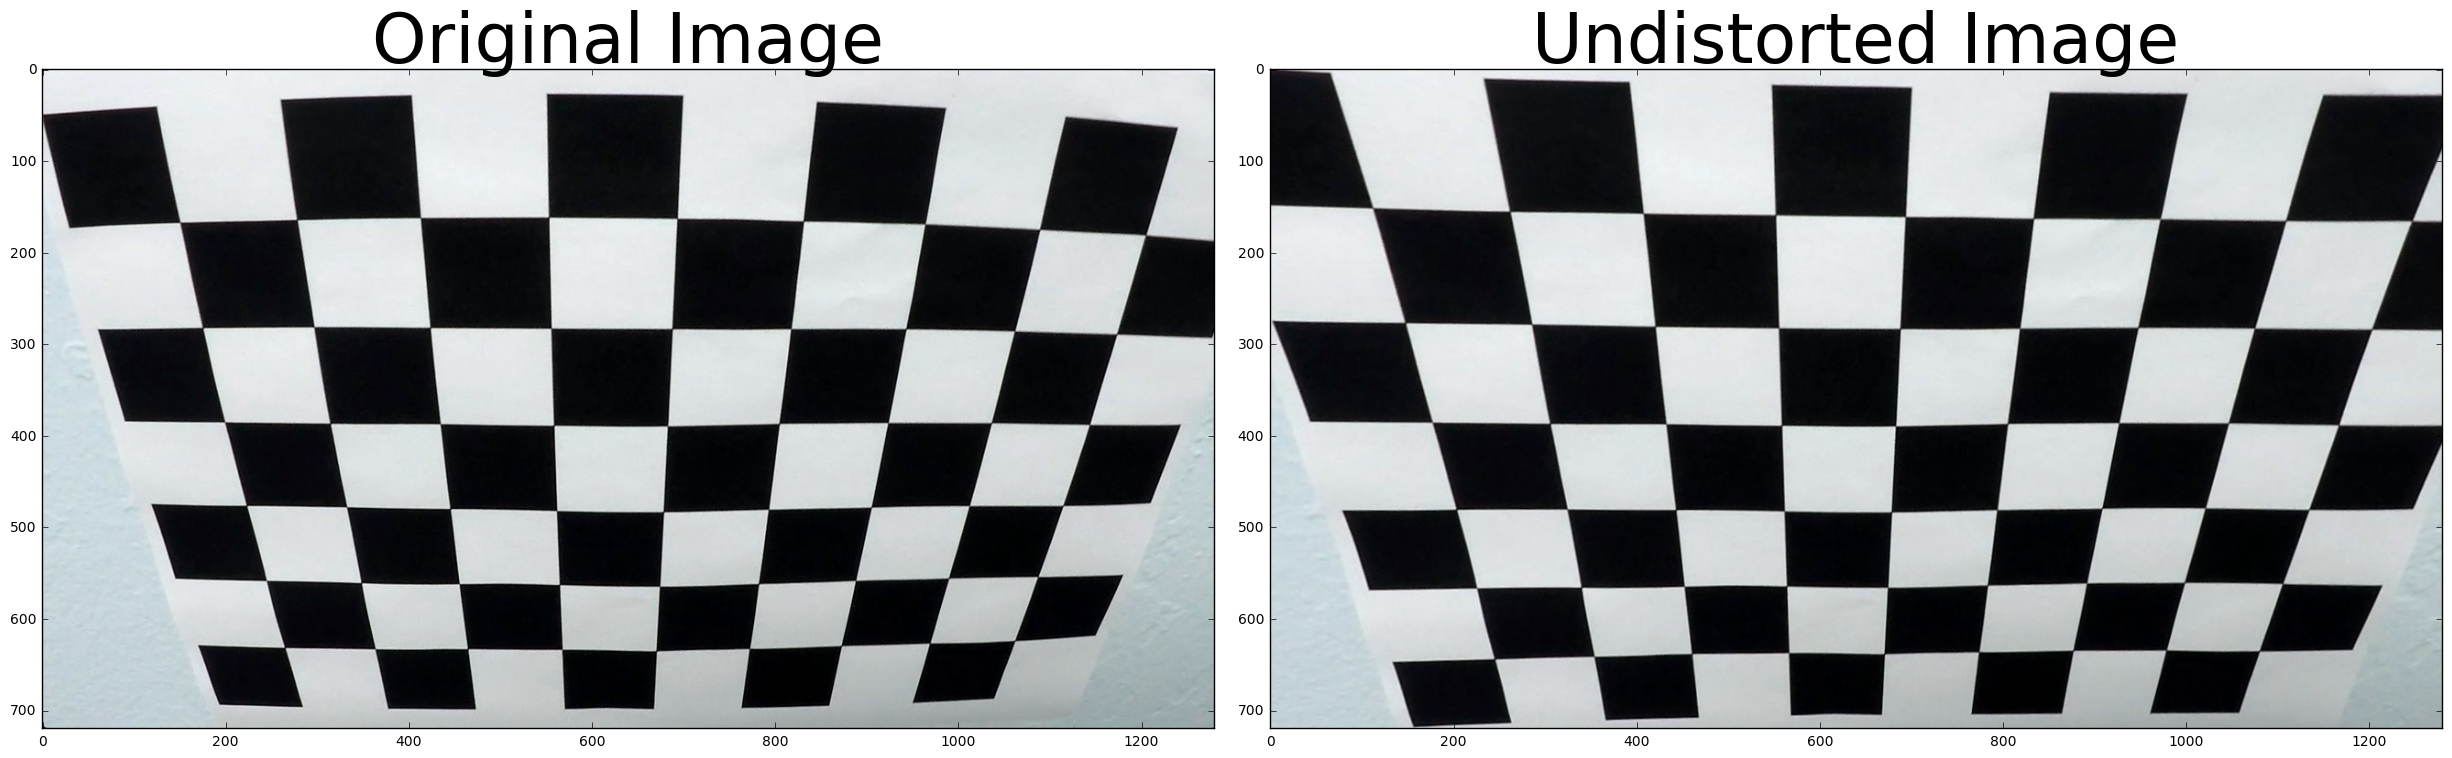

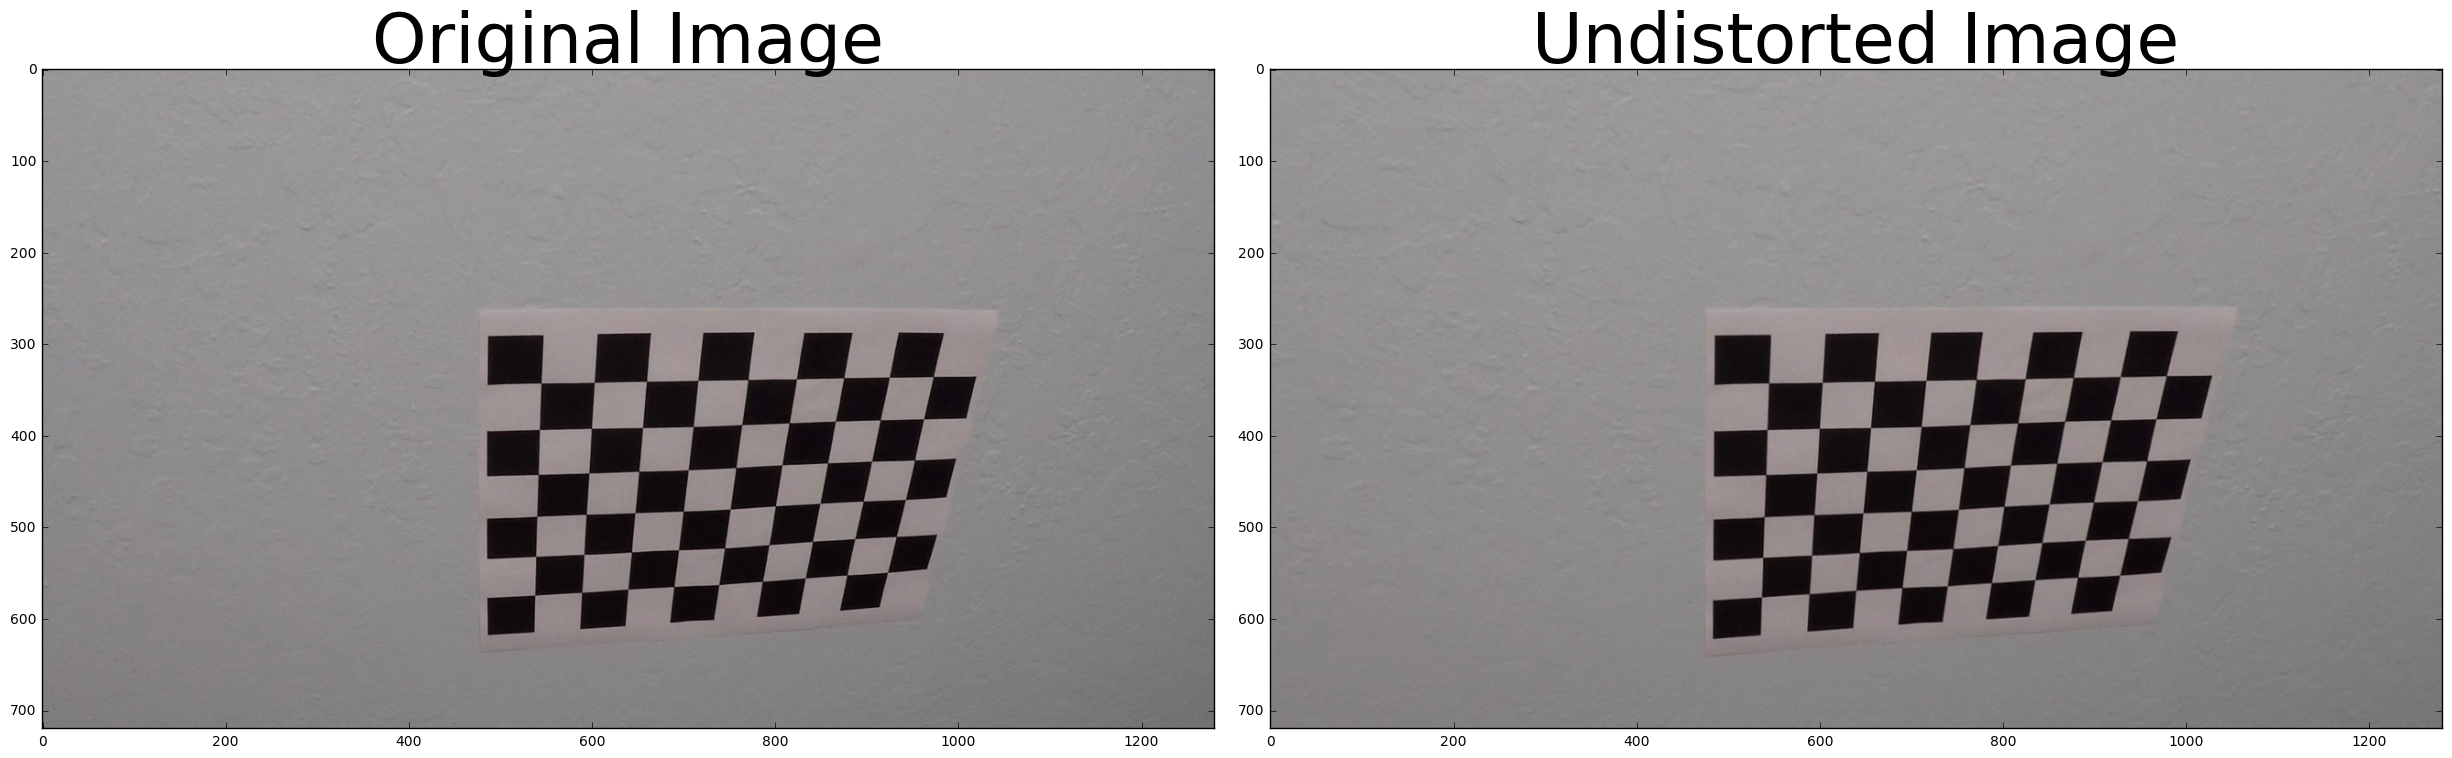

In [3]:
# verify code to calibrate camera and undistort images
dist_pickle = pickle.load(open('../camera_cal/calibration.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

for n in [1, 2, 10]:
    img = cv2.imread('../camera_cal/calibration{}.jpg'.format(n))    
    show_original_and_undistorted(img, mtx, dist)

## Use color transforms, gradients, etc., to create a thresholded binary image
* https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c53a9a18-d31b-4fd7-bc44-07070507abd8
* https://github.com/SamSamskies/combining-thresholds

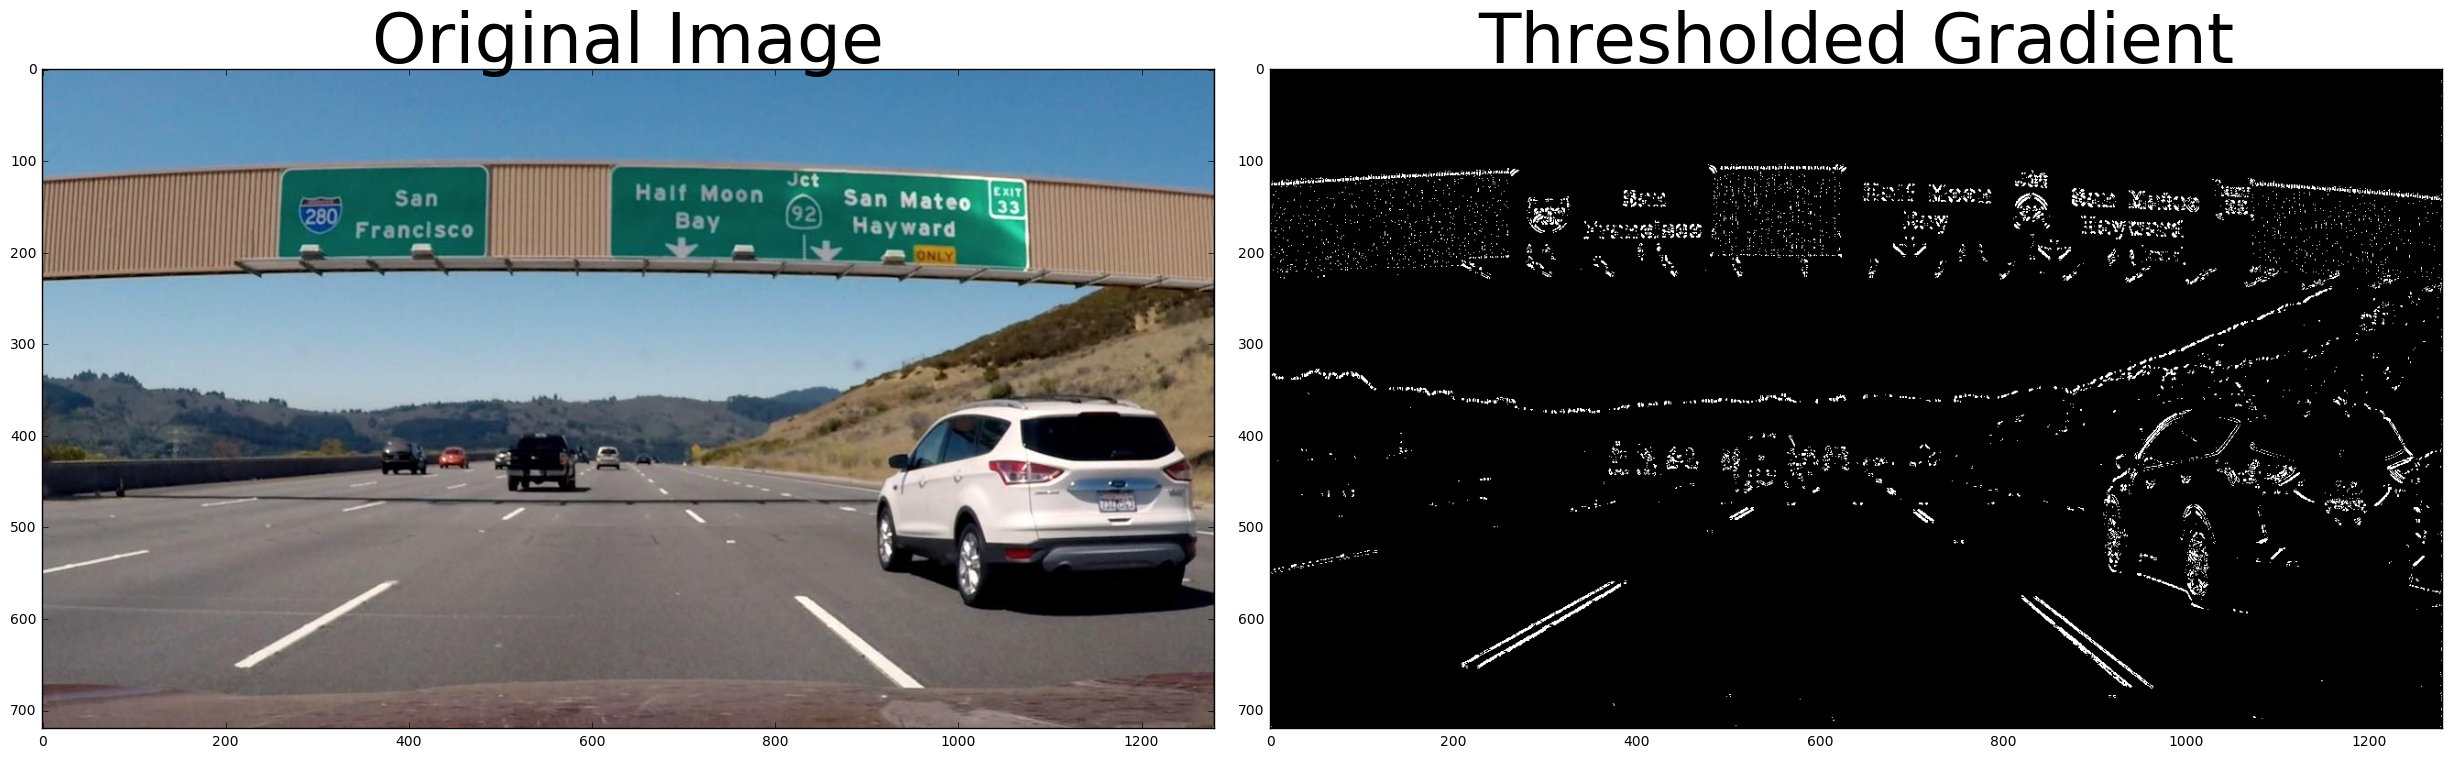

In [35]:
image = mpimg.imread('../test_images/binary-threshold.png')

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_thresh(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view")
* https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/ae58b4d0-b909-4f4b-9332-67d80a1b4029

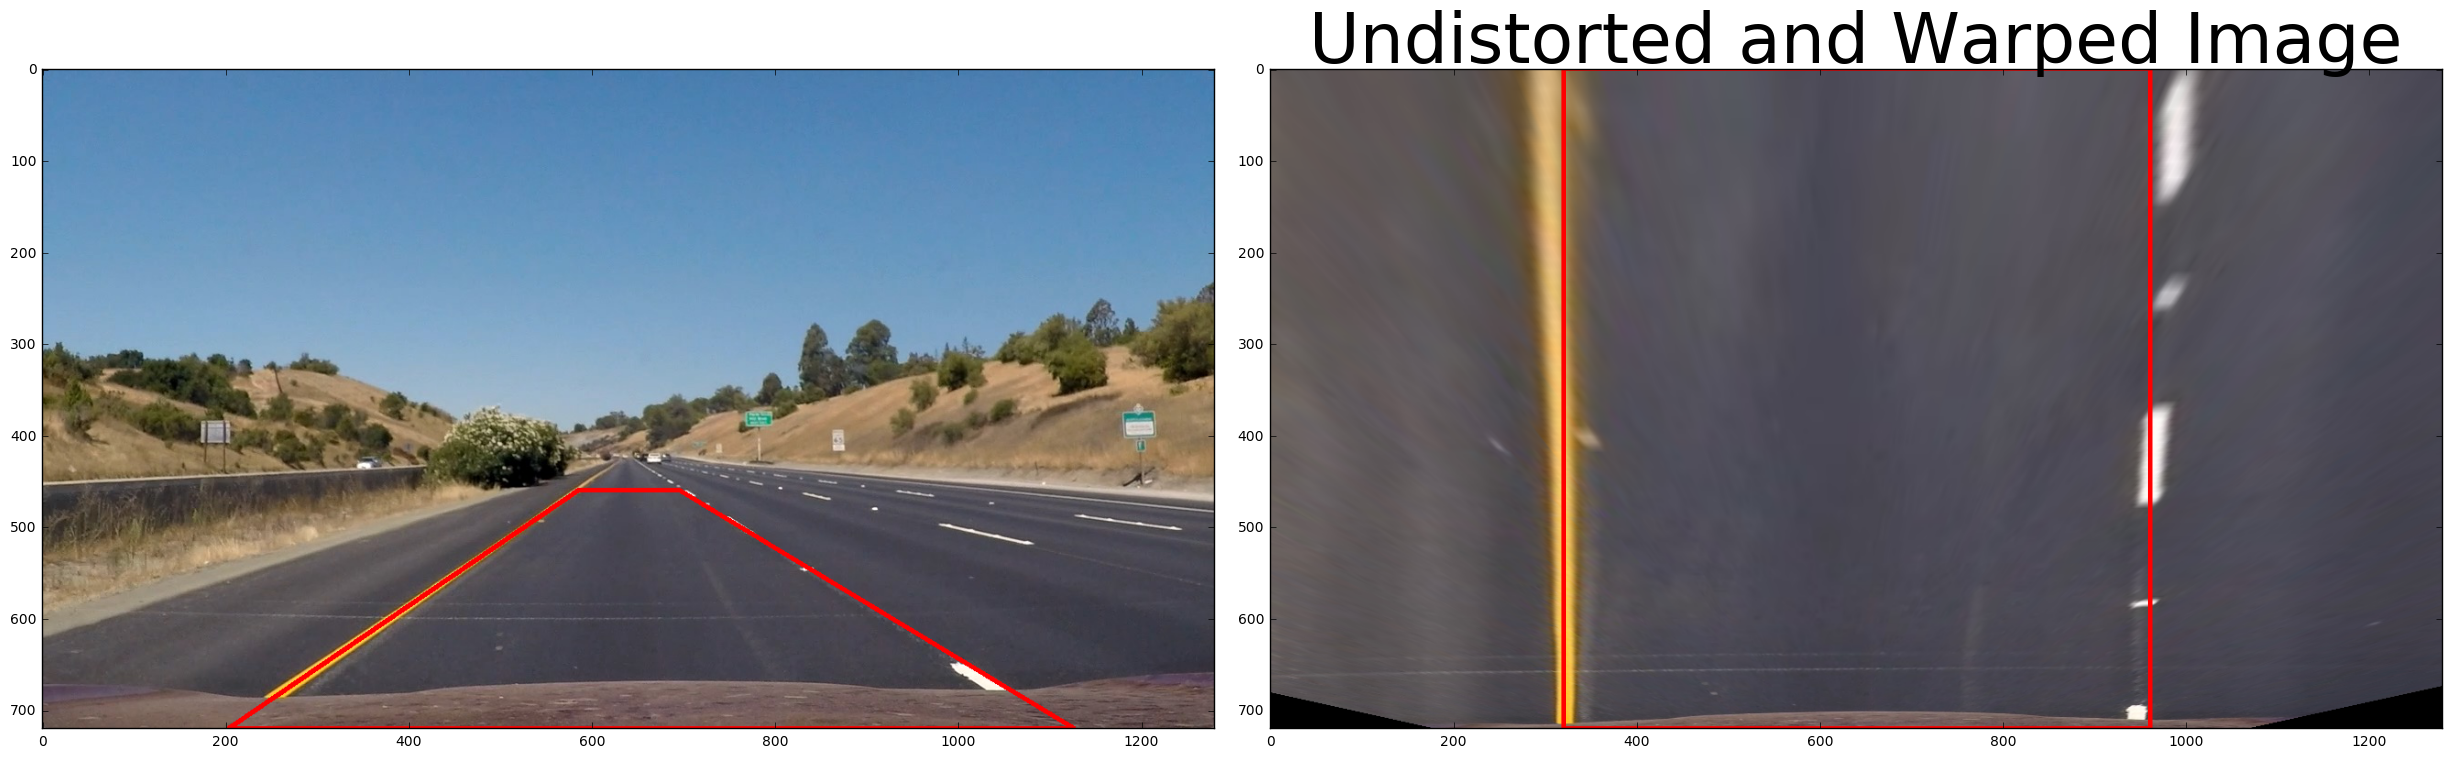

In [28]:
image = mpimg.imread('../test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

top_down, perspective_M = corners_unwarp(image, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

draw_original_lines(image)
ax1.imshow(image)

draw_warped_lines(top_down)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary
* https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a

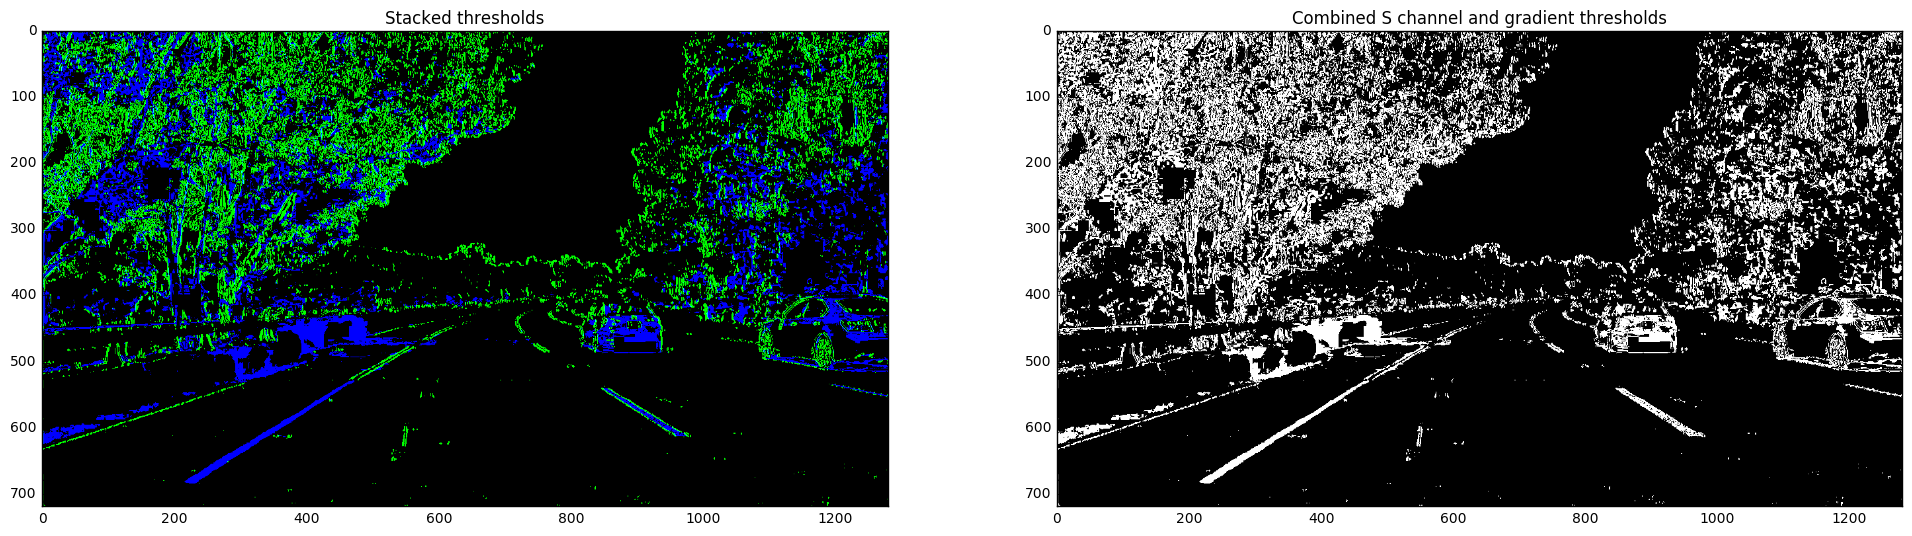

In [34]:
# verify color and gradient thresholds
dist_pickle = pickle.load(open('../camera_cal/calibration.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
image = mpimg.imread('../test_images/test5.jpg')
sobelx_binary = abs_sobel_thresh(image)
s_channel_binary = color_thresh(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.set_title('Stacked thresholds')
ax1.imshow(stacked_color_and_gradient_thresh(sobelx_binary, s_channel_binary))

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_color_and_gradient_thresh(sobelx_binary, s_channel_binary), cmap='gray')

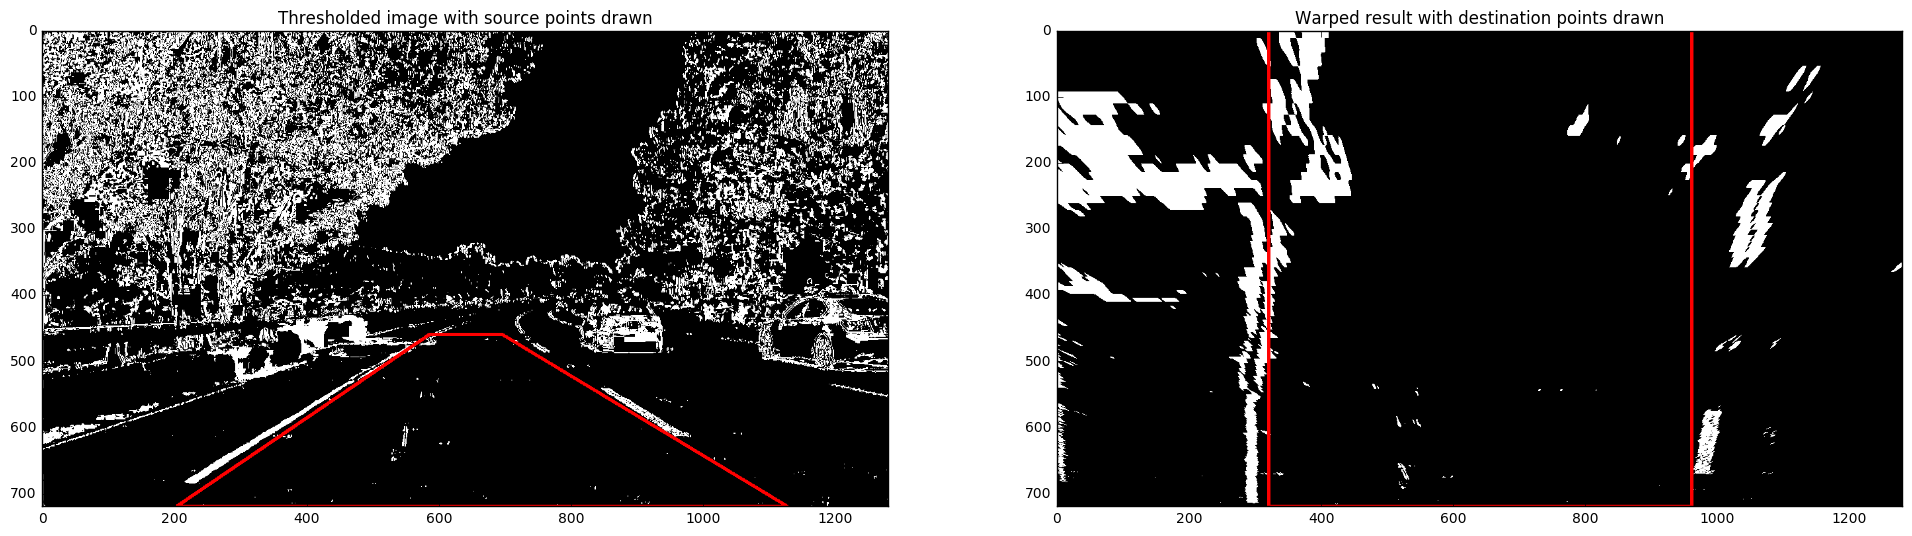

In [5]:
# verify curved thresholded lines
dist_pickle = pickle.load(open('../camera_cal/calibration.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
image = mpimg.imread('../test_images/test5.jpg')
sobelx_binary = abs_sobel_thresh(image)
s_channel_binary = color_thresh(image)
thresholded_image = combined_color_and_gradient_thresh(sobelx_binary, s_channel_binary)
top_down, perspective_M = corners_unwarp(thresholded_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.set_title('Thresholded image with source points drawn')
thresholded_image = np.dstack((thresholded_image, thresholded_image, thresholded_image))*255
draw_original_lines(thresholded_image)
ax1.imshow(thresholded_image)

ax2.set_title('Warped result with destination points drawn')
top_down = np.dstack((top_down , top_down , top_down ))*255
draw_warped_lines(top_down)
ax2.imshow(top_down)

/Users/miyakawa/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:165: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


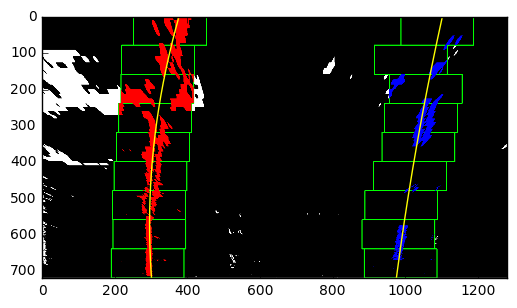

In [7]:
# Locate the Lane Lines and Fit a Polynomial
dist_pickle = pickle.load(open('../camera_cal/calibration.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
image = mpimg.imread('../test_images/test5.jpg')
sobelx_binary = abs_sobel_thresh(image)
s_channel_binary = color_thresh(image)
thresholded_image = combined_color_and_gradient_thresh(sobelx_binary, s_channel_binary)
binary_warped, perspective_M = corners_unwarp(thresholded_image, mtx, dist)
sliding_windows(binary_warped, visualize=True)